## Perform planning on raw input images with Neural A*

Neural A* can also be trained to perform plannig on a raw image input. Here we present some examples with WarCraft dataset available at  [Blackbox Combinatorial Solvers page](https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.YJCQ5S).

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from neural_astar.planner import NeuralAstar
from neural_astar.utils.data import create_warcraft_dataloader
from neural_astar.utils.training import load_from_ptl_checkpoint

/home/yonetani/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Just like the cases with shortest-path search problems, we prepare a dataset consisting of `map_designs`, `start_maps`, `goal_maps`, and `opt_trajs`. But this time `map_designs` are colored images instead of binary obstacle maps.

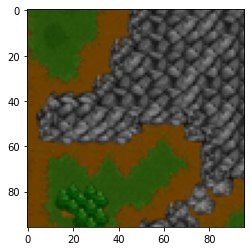

In [2]:
dataloader = create_warcraft_dataloader("../12x12/", "test", 10)
map_designs, start_maps, goal_maps, opt_trajs = next(iter(dataloader))

plt.imshow(map_designs[0].permute(1, 2, 0))

For training with such real images, Neural A* is configured to have (1) `rgb+` inputs consisting of RGB images and binary start+goal maps and (2) `learn_obstacles=True` indicating that the visual representation of obstacles is learned during training. Other args `encoder_arch`, `encoder_depth`, and `const` are also set properly for handling warcraft data.

In [3]:
model = NeuralAstar(encoder_input="rgb+", encoder_arch="CNNDownSize", encoder_depth=3, learn_obstacles=True, Tmax=1.0, const=10.)
model.load_state_dict(load_from_ptl_checkpoint("../model/12x12/lightning_logs"))

load ../model/12x12/lightning_logs/version_0/checkpoints/epoch=38-step=3900.ckpt


<All keys matched successfully>

Then, Neural A* can be used in the same manner as for shortest path search.

/home/yonetani/.venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


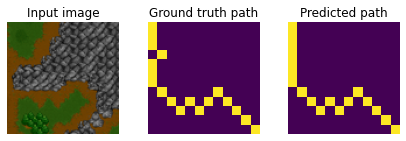

In [4]:
outputs = model(map_designs, start_maps, goal_maps)

t = 0
fig, axes = plt.subplots(1, 3, figsize=[6, 2])
axes[0].imshow(map_designs[t].permute(1, 2, 0))
axes[0].axis("off")
axes[1].imshow(opt_trajs[t, 0])
axes[0].set_title("Input image")
axes[1].axis("off")
axes[1].set_title("Ground truth path")
axes[2].imshow(outputs.paths[t, 0])
axes[2].axis("off")
axes[2].set_title("Predicted path")
fig.tight_layout()
plt.savefig("../assets/warcraft.png")